In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
from enum import StrEnum
from scipy.stats import spearmanr
sns.set_palette("tab20")

In [110]:
folder_to_models = "models_to_plot"
model_files = list(Path(folder_to_models).glob("**/*.csv"))

In [111]:
model_files

[PosixPath('models_to_plot/gpt-4.1-mini_fewshot.csv'),
 PosixPath('models_to_plot/gpt-4.1-mini.csv'),
 PosixPath('models_to_plot/gpt-4.1-nano.csv'),
 PosixPath('models_to_plot/llama_31_8b_tuned.csv'),
 PosixPath('models_to_plot/judgelm_llama_31_8b_ckpt_ep2_merged.csv')]

# Textdetox 2024

In [180]:
df_path = Path(Path.cwd().parent, "dataset/test_all_metrics-textdetoxeval.csv")
df_test = pd.read_csv(df_path)
df_test["J"] = df_test["fluency_score"] * df_test["content_score"] * df_test["toxic_pairwise_score"]

In [181]:
df_test_merged = df_test[df_test.participant_name.isin(
    ['SomethingAwful', 'VitalyProtasov', 'Team_SINAI', 'gleb.shnshn', 'backtranslation_baseline', 'ZhongyuLuo']
)].copy()

In [182]:
lang_map_dict = {
    "Amharic": "am",
    "Chinese": "zh",
    "English": "en",
    "Spanish": "es",
    "Hindi": "hi",
    "German": "de",
    "Russian": "ru",
    "Ukrainian": "uk",
    "Arabic": "ar",
}

lang_map_dict_reverse = {v: k for k, v in lang_map_dict.items()}
df_test_merged["full_lang"] = df_test_merged["lang"].apply(lambda x: lang_map_dict_reverse[x])

In [183]:
df_test_merged.lang.value_counts()

lang
am    480
ar    480
zh    480
en    480
de    480
hi    480
ru    480
es    480
uk    480
Name: count, dtype: int64

In [184]:
class BasicColumns(StrEnum):
    content_score = "content_score"
    fluency_score = "fluency_score"
    toxic_pairwise_score = "toxic_pairwise_score"
    J = "J"

gold_J = df_test_merged[BasicColumns.content_score] * df_test_merged[BasicColumns.fluency_score] * df_test_merged[BasicColumns.toxic_pairwise_score]

In [185]:
model_suffix = "model_"

for f in model_files:
    _df = pd.read_csv(f)

    for c in list(BasicColumns):
        try:
            df_test_merged[f"{model_suffix}{f.stem}_{c.value}"] = _df[c.value].tolist()
        except:
            pass


In [186]:
df_test_merged.columns

Index(['Unnamed: 0', 'toxic_sentence', 'neutral_sentence', 'lang',
       'toxic_fluency', 'neutral_fluency', 'fluency_score', 'content_score',
       'toxic_pairwise_score', 'participant_name', 'neutral_sentence_gold',
       'chrf', 'wmt22-comet-da', 'XCOMET-XL', 'XCOMET-XXL', 'XCOMET-LITE',
       'SIM-INPUT-GEN', 'SIM-GEN-REF', 'CLS_NEW_INPUT', 'CLS_NEW_GEN',
       'CLS_NEW_REF', 'CLS_OLD_INPUT', 'CLS_OLD_GEN', 'CLS_OLD_REF', 'J',
       'full_lang', 'model_gpt-4.1-mini_fewshot_content_score',
       'model_gpt-4.1-mini_fewshot_fluency_score',
       'model_gpt-4.1-mini_fewshot_toxic_pairwise_score',
       'model_gpt-4.1-mini_content_score', 'model_gpt-4.1-mini_fluency_score',
       'model_gpt-4.1-mini_toxic_pairwise_score',
       'model_gpt-4.1-nano_content_score', 'model_gpt-4.1-nano_fluency_score',
       'model_gpt-4.1-nano_toxic_pairwise_score',
       'model_llama_31_8b_tuned_content_score',
       'model_llama_31_8b_tuned_fluency_score',
       'model_llama_31_8b_tuned_t

In [187]:
sim_w_prod_score = []

c_ig = 0.4
c_gr = 0.6
for i, row in df_test_merged.iterrows():
    sim_w_prod_score.append(
        row['SIM-INPUT-GEN'] * c_ig + row['SIM-GEN-REF'] * c_gr
    )
    
df_test_merged["SIM-PROD"] = sim_w_prod_score


new_prod1 = []
new_prod2 = []

for i, row in df_test_merged.iterrows():
    new_prod1.append(
         max(
              (row["CLS_NEW_GEN"] + int(row["CLS_NEW_INPUT"] <= row["CLS_NEW_GEN"])) / 2,
              int(row["CLS_NEW_REF"] <= row["CLS_NEW_GEN"])
          )
    )
    
    new_prod2.append(
         max(
              (row["CLS_OLD_GEN"] + int(row["CLS_OLD_INPUT"] <= row["CLS_OLD_GEN"])) / 2,
              int(row["CLS_OLD_REF"] <= row["CLS_OLD_GEN"])
          )
    )
    
df_test_merged["CLS-PROD"] = new_prod1

In [188]:
# add J metrics
df_test_merged["J-PROD"] = df_test_merged["XCOMET-LITE"] * df_test_merged["CLS-PROD"] * df_test_merged["SIM-PROD"]

df_test_merged['gpt-4.1-nano_J'] = df_test_merged['model_gpt-4.1-nano_fluency_score']*df_test_merged['model_gpt-4.1-nano_content_score']*df_test_merged['model_gpt-4.1-nano_toxic_pairwise_score']
df_test_merged['gpt-4.1-mini_J'] = df_test_merged['model_gpt-4.1-mini_fluency_score']*df_test_merged['model_gpt-4.1-mini_content_score']*df_test_merged['model_gpt-4.1-mini_toxic_pairwise_score']
df_test_merged['gpt-4.1-mini_fewshot_J'] = df_test_merged['model_gpt-4.1-mini_fewshot_fluency_score']*df_test_merged['model_gpt-4.1-mini_fewshot_content_score']*df_test_merged['model_gpt-4.1-mini_fewshot_toxic_pairwise_score']

df_test_merged['J-XCOMET-LITE & gpt-4.1-mini_fewshot'] = df_test_merged["XCOMET-LITE"] * df_test_merged[model_suffix+'gpt-4.1-mini_fewshot_toxic_pairwise_score']
df_test_merged['J-XCOMET-LITE & FT-LLAMA-TOX'] = df_test_merged["XCOMET-LITE"] * df_test_merged[model_suffix+'llama_31_8b_tuned_toxic_pairwise_score']
df_test_merged['J-XCOMET-LITE & FT-LLAMA-EPOCH2-toxic'] = df_test_merged["XCOMET-LITE"] * df_test_merged[model_suffix+'judgelm_llama_31_8b_ckpt_ep2_merged_toxic_pairwise_score']
df_test_merged['J-XCOMET-LITE & FT-LLAMA-EPOCH2-toxic-content'] = df_test_merged["XCOMET-LITE"] * df_test_merged[model_suffix+'judgelm_llama_31_8b_ckpt_ep2_merged_toxic_pairwise_score'] * df_test_merged[model_suffix+'judgelm_llama_31_8b_ckpt_ep2_merged_content_score']

In [189]:
df_test_merged.columns

Index(['Unnamed: 0', 'toxic_sentence', 'neutral_sentence', 'lang',
       'toxic_fluency', 'neutral_fluency', 'fluency_score', 'content_score',
       'toxic_pairwise_score', 'participant_name', 'neutral_sentence_gold',
       'chrf', 'wmt22-comet-da', 'XCOMET-XL', 'XCOMET-XXL', 'XCOMET-LITE',
       'SIM-INPUT-GEN', 'SIM-GEN-REF', 'CLS_NEW_INPUT', 'CLS_NEW_GEN',
       'CLS_NEW_REF', 'CLS_OLD_INPUT', 'CLS_OLD_GEN', 'CLS_OLD_REF', 'J',
       'full_lang', 'model_gpt-4.1-mini_fewshot_content_score',
       'model_gpt-4.1-mini_fewshot_fluency_score',
       'model_gpt-4.1-mini_fewshot_toxic_pairwise_score',
       'model_gpt-4.1-mini_content_score', 'model_gpt-4.1-mini_fluency_score',
       'model_gpt-4.1-mini_toxic_pairwise_score',
       'model_gpt-4.1-nano_content_score', 'model_gpt-4.1-nano_fluency_score',
       'model_gpt-4.1-nano_toxic_pairwise_score',
       'model_llama_31_8b_tuned_content_score',
       'model_llama_31_8b_tuned_fluency_score',
       'model_llama_31_8b_tuned_t

In [190]:
dict_map_metrics_models = {
    "fluency_score": ["XCOMET-LITE"],
    "content_score": ["XCOMET-LITE", "SIM-PROD"],
    "toxic_pairwise_score": ["CLS-PROD"],
    "J": [
        'J-PROD',
        'J-XCOMET-LITE & gpt-4.1-mini_fewshot',
        'gpt-4.1-nano_J',
        'gpt-4.1-mini_J',
        'gpt-4.1-mini_fewshot_J',
        'J-XCOMET-LITE & FT-LLAMA-EPOCH2-toxic',
        'J-XCOMET-LITE & FT-LLAMA-EPOCH2-toxic-content'
        ]
}

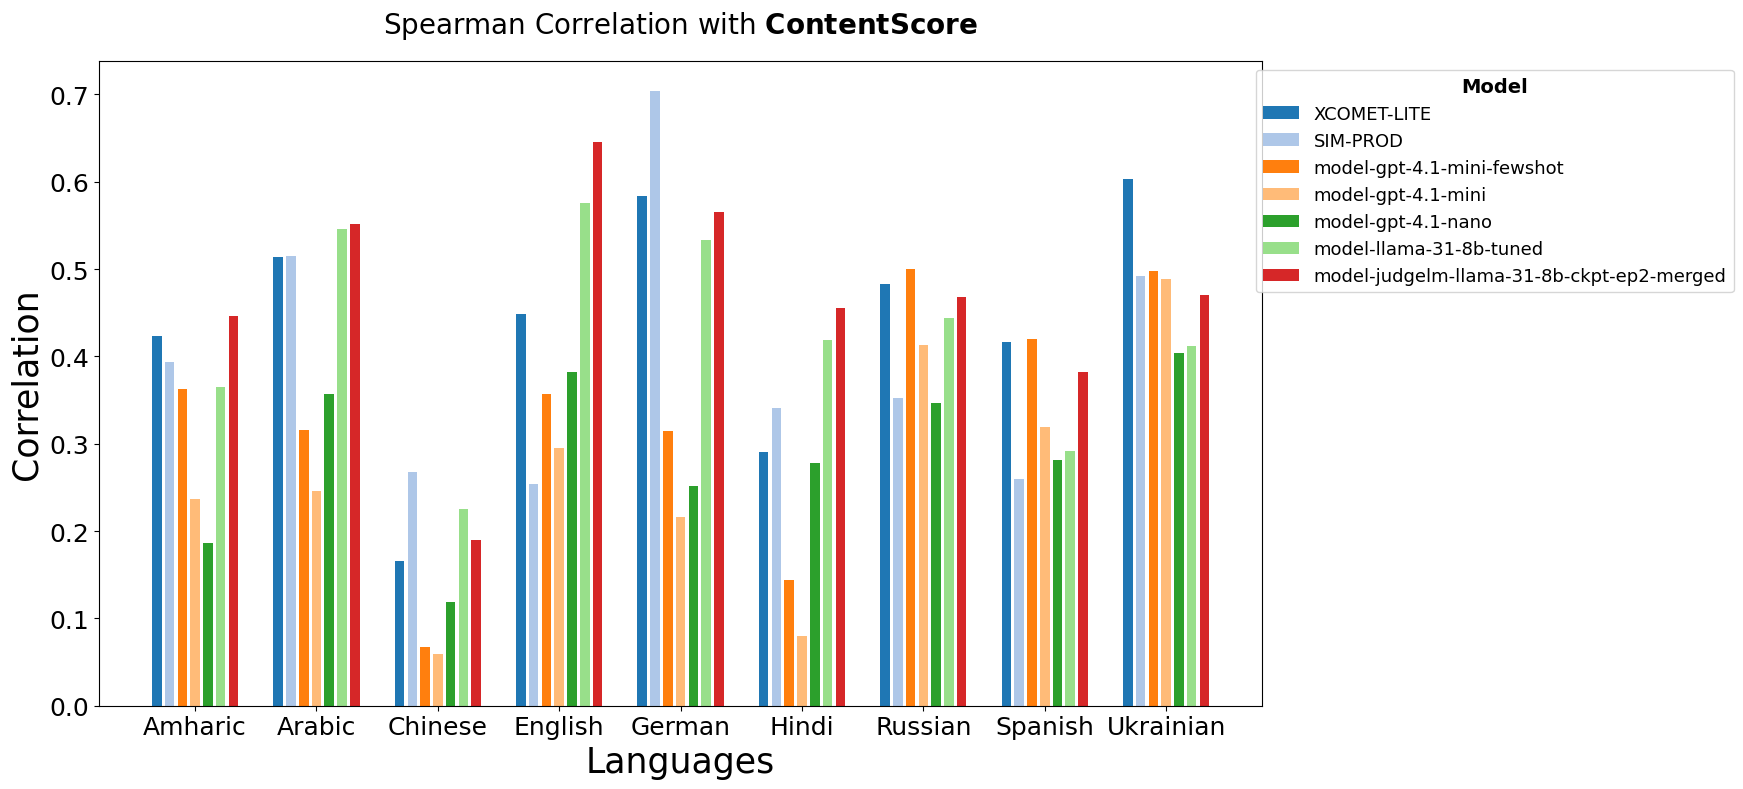

/tmp/ipykernel_1197802/3592912330.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = spearmanr(
/tmp/ipykernel_1197802/3592912330.py:17: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = spearmanr(


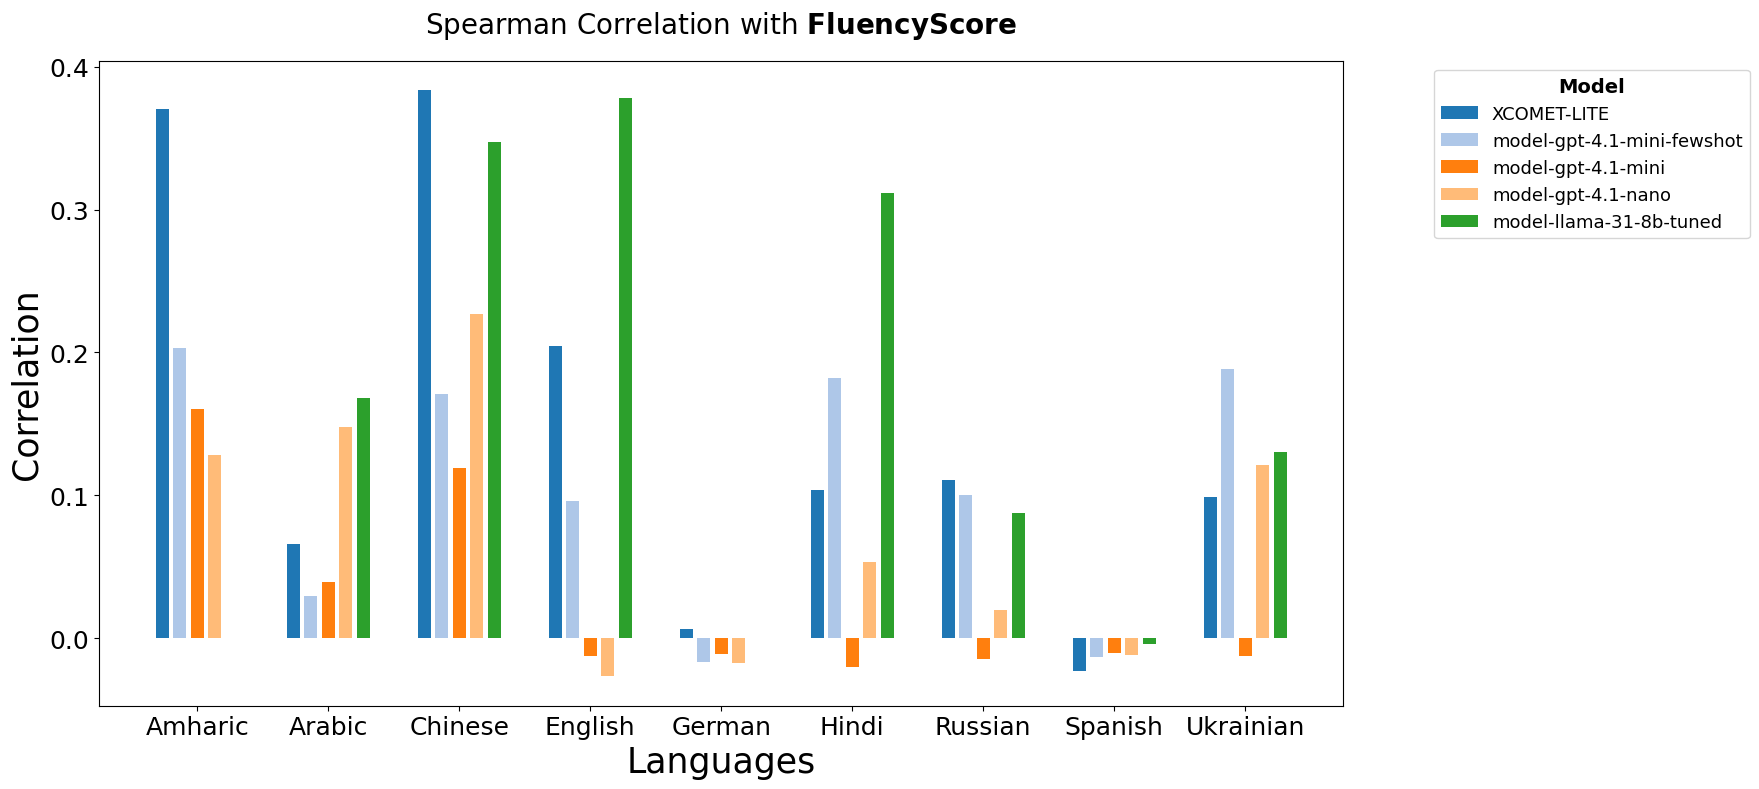

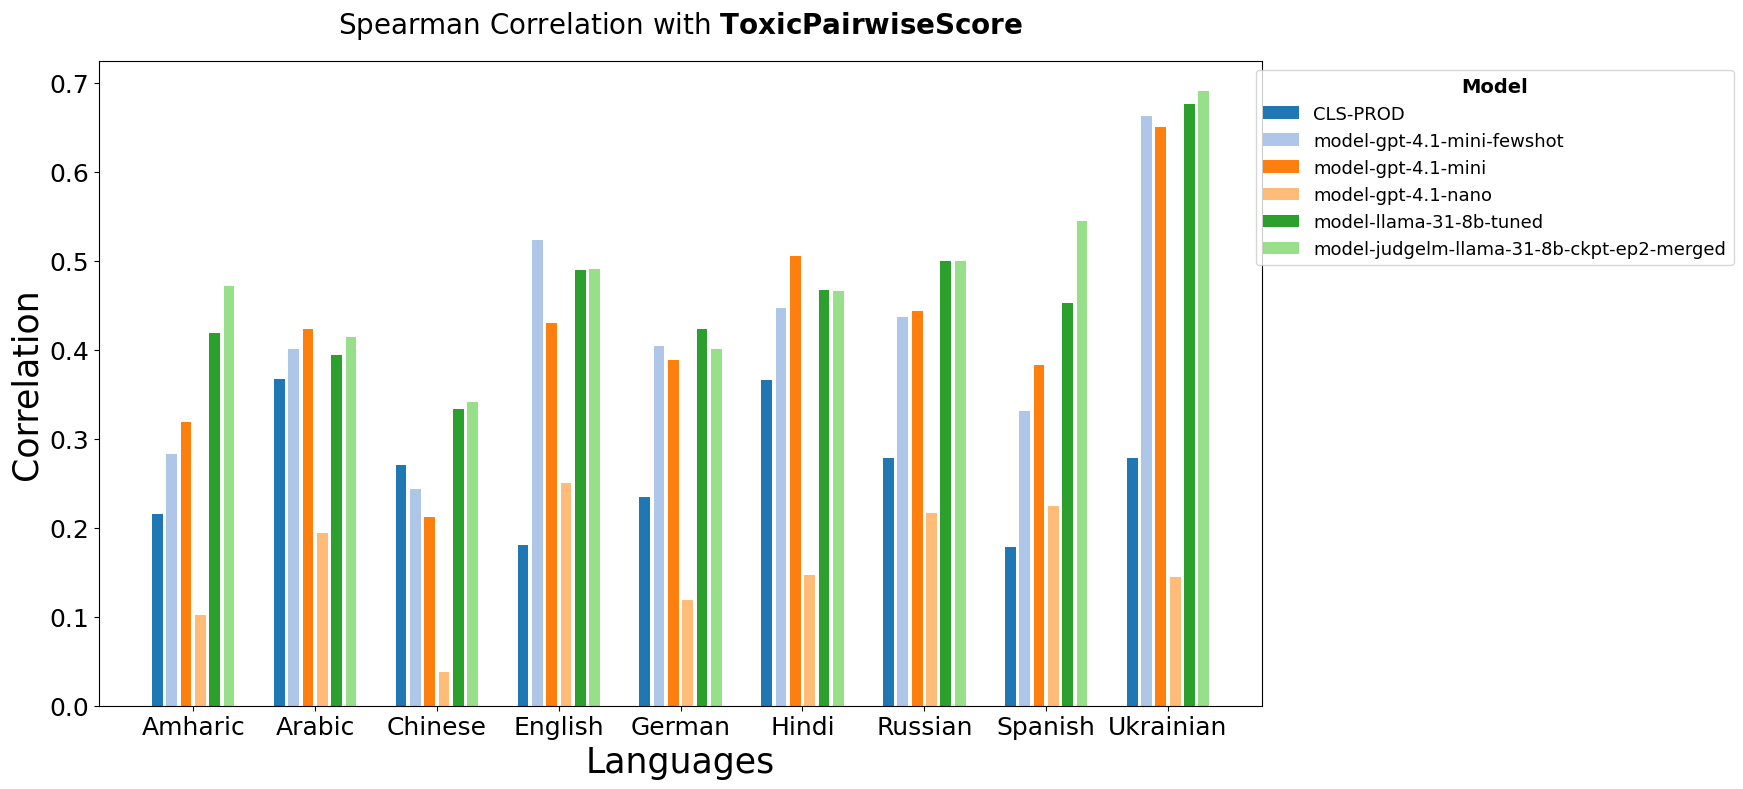

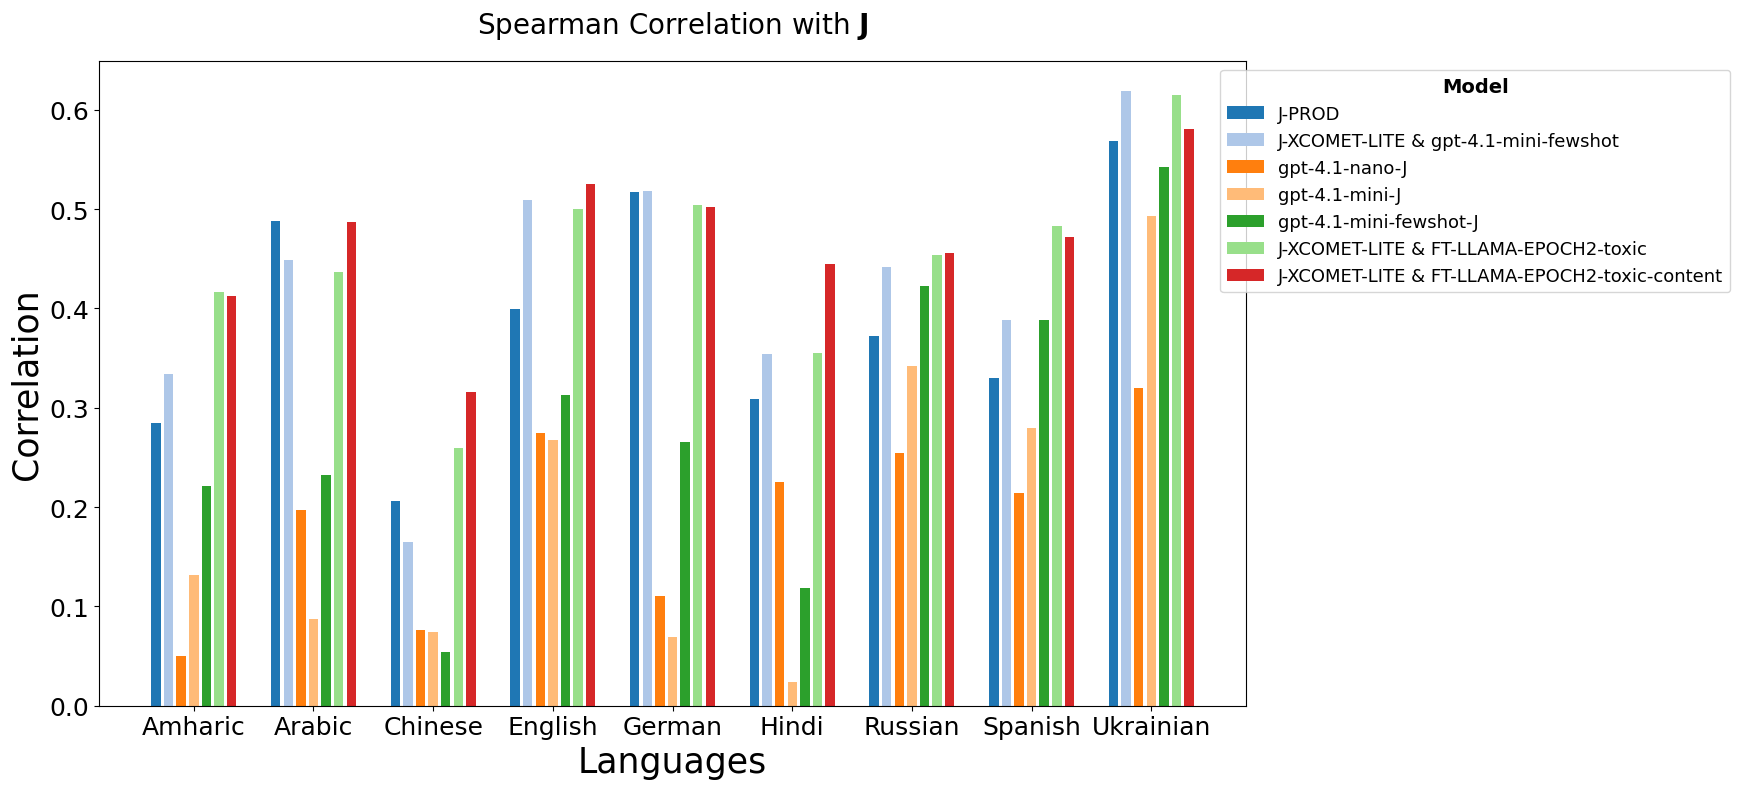

In [191]:
lang_name = "full_lang"

for c in list(BasicColumns):
    basic_column_metric_name = c.value
    
    if basic_column_metric_name in df_test_merged.columns:
        calculated_models = dict_map_metrics_models.get(basic_column_metric_name, [])
        models = calculated_models + [c for c in df_test_merged.columns if basic_column_metric_name in c and c.startswith(model_suffix)]
        
        
        # Calculate Spearman correlations for each language and model
        results = []
        for lang in df_test_merged[lang_name].unique():
            lang_data = df_test_merged[df_test_merged[lang_name] == lang]
            for model in models:
                if basic_column_metric_name in lang_data.columns and model in lang_data.columns:
                    corr, pval = spearmanr(
                        lang_data.dropna(subset=model)[basic_column_metric_name],
                        lang_data.dropna(subset=model)[model],
                    )
                    results.append({
                        'lang': lang,
                        'metric': basic_column_metric_name,
                        'model': model,
                        'correlation': corr,
                        'p_value': pval
                    })

        results_df = pd.DataFrame(results)
        
        # Visualization
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
        # Filter data for current metric
        metric_data = results_df[results_df['metric'] == basic_column_metric_name].pivot(index='lang', columns='model', values='correlation')
        
        # Get dimensions
        n_langs = len(metric_data.index)
        n_models = len(models)
        
        # Set dimensions
        bar_width = 0.15
        model_gap = 0.05
        language_gap = 0.5
        
        # Create positions
        index = np.arange(n_langs) * (n_models * (bar_width + model_gap) + language_gap)
        
        # Plot each model's bars
        for i, model in enumerate(models):
            if model in metric_data.columns:
                pos = index + i * (bar_width + model_gap)
                ax.bar(pos, metric_data[model], width=bar_width, label=model)
        
        # Customize plot
        ax.set_title(
            r'Spearman Correlation with $\mathbf{' + basic_column_metric_name.replace("_", " ").title() + '}$', 
            pad=20, 
            fontsize=20
        )
        ax.set_ylabel('Correlation', size=25)
        ax.set_xlabel('Languages', size=25)
        ax.set_xticks(index + (n_models-1)*(bar_width + model_gap)/2)
        ax.set_xticklabels(metric_data.index, fontsize=13)
        
        # Add significance markers (optional)
        for i, lang in enumerate(metric_data.index):
            for j, model in enumerate(models):
                if model in metric_data.columns:
                    pval = results_df[(results_df['metric'] == basic_column_metric_name) & 
                                    (results_df['lang'] == lang) & 
                                    (results_df['model'] == model)]['p_value'].values[0]
        
        ax.tick_params(axis='y', labelsize=18)
        ax.tick_params(axis='x', labelsize=18)

        # Get the current handles and labels
        handles, labels = ax.get_legend_handles_labels()

        # Replace underscores with hyphens in the labels
        new_labels = [label.replace('_', '-').replace("-fluency-score", "").replace("-content-score", "").replace("-toxic-pairwise-score", "") for label in labels]
        
        ax.legend(title='Model', bbox_to_anchor=(1.2, 1), loc='upper center', fontsize=13, handles=handles, labels=new_labels,
                title_fontproperties={'size': 14, 'weight': 'bold'}
                )

    plt.tight_layout()
    plt.show()
    # fig.savefig(f"imgs/{basic_column_name}.pdf", bbox_inches='tight')